In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
from x2 import X2Env, print_grid
from stable_baselines3.common.env_checker import check_env
from eval import eval_model
from checkpoint import load_from_checkpoint, load_rewards
import pandas as pd
import numpy as np

check_env(X2Env())

In [4]:
import plotly.express as px
import polars as pl

rs = load_rewards("3eccbcb1-894f-4721-810b-fd5d0279cb73")

df = rs.group_by("iter").agg(pl.col("reward").mean()).to_pandas()

px.line(df, x="iter", y="reward")

JSONDecodeError: Extra data: line 1 column 43866 (char 43865)

92.8077 33.25301370868512


array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

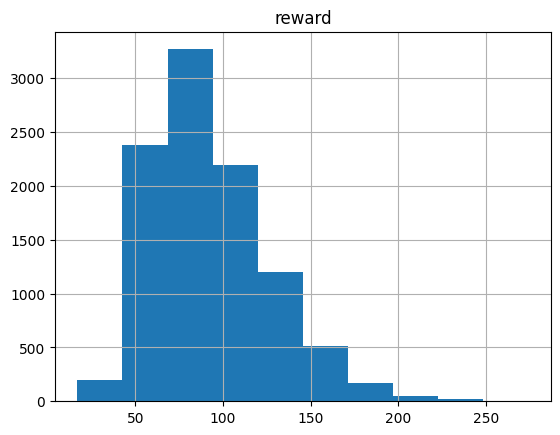

In [3]:
uuid = '3eccbcb1-894f-4721-810b-fd5d0279cb73'
model, _ = load_from_checkpoint(uuid)

rewards = eval_model(model)

print(rewards.mean(), rewards.std())

df = pd.DataFrame(rewards, columns=["reward"])
df.hist()

In [4]:
seed = int(np.argmax(rewards))
print(seed, print(np.max(rewards)))

env = X2Env()
state, _ = env.reset(seed=seed)

iter = 0

274
3015 None


In [296]:
s = env.get_state()

print_grid(s.grid)

action, _ = model.predict(state, deterministic=True)

print(f"iter: {iter}, next: {s.next_play} action: {action}")

next_state, reward, done, _, _ = env.step(action)

print_grid(s.grid)
iter += 1

0010 0011 0007 0009 0010
0009 0007 0001 0008 0005
0008 0006 0003 0005 0007
0007 0005 0002 0004 0005
0001 0007 0003 0002 0006
iter: 291, next: 4 action: 0
0010 0011 0007 0009 0010
0009 0007 0001 0008 0005
0008 0006 0003 0005 0007
0007 0005 0002 0004 0005
0001 0007 0003 0002 0006
